In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from csbms import MultiClassCSBM, StructureCSBM
from CSBMhet import CSBMhet
from CSBMhom import CSBMhom
from metrics import mmd_linear

import torch
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import homophily

In [2]:
dimensions = 100
n = 50
classes = 20
training_time = 5

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [5]:
@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

In [6]:
def model_training(csbm):
    data = csbm.data
    model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0).to(device)

    num_workers = 4 if sys.platform == 'linux' else 0
    loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
    accuracy = 0
    for epoch in range(training_time):
        loss = train(model, loader, optimizer)
        acc = test(model, data)
        accuracy = max(acc, accuracy)
    return model.embedding.weight.cpu().detach().numpy()

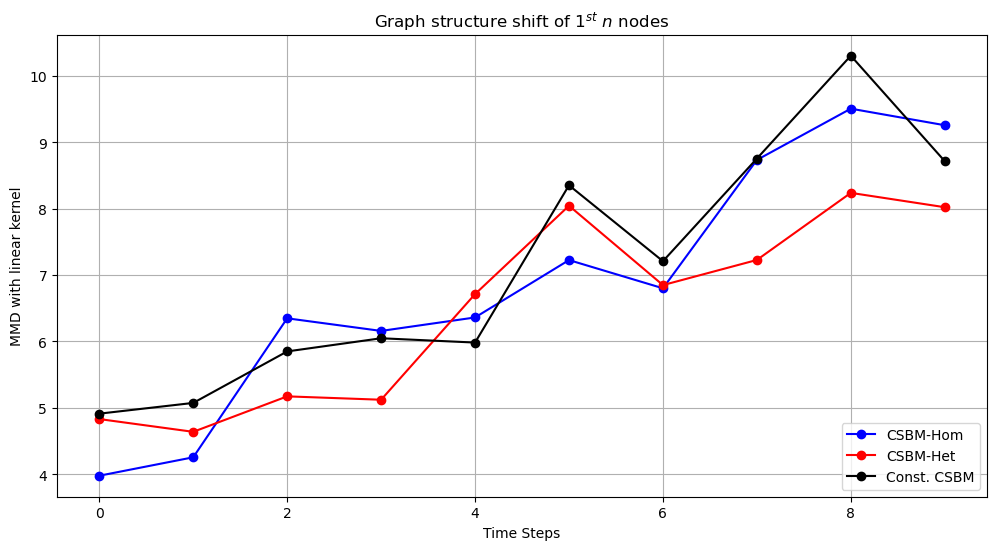

In [7]:
time_steps = []

mmd_hom_first = []
mmd_het_first = []
mmd_const_first = []

mmd_hom_curr = []
mmd_het_curr = []
mmd_const_curr = []

csbm_hom = CSBMhom(n=n, dimensions=dimensions, classes=classes, q_hom=0.05)
csbm_het = CSBMhet(n=n, dimensions=dimensions, classes=classes, q_het=0.05)
csbm_const = MultiClassCSBM(n=n, dimensions=dimensions, classes=classes)

initial_embedding_hom = model_training(csbm_hom)
initial_embeddings_het = model_training(csbm_het)
initial_embeddings_const = model_training(csbm_const)

for t in range(10):
    time_steps.append(t)

    embedding_hom = model_training(csbm_hom)
    mmd_hom_first.append(mmd_linear(initial_embedding_hom, embedding_hom[:n]))
    mmd_hom_curr.append(mmd_linear(initial_embedding_hom, embedding_hom[-n:]))

    embedding_het = model_training(csbm_het)
    mmd_het_first.append(mmd_linear(initial_embeddings_het, embedding_het[:n]))
    mmd_het_curr.append(mmd_linear(initial_embeddings_het, embedding_het[-n:]))

    embedding_const = model_training(csbm_const)
    mmd_const_first.append(mmd_linear(initial_embeddings_const, embedding_const[:n]))
    mmd_const_curr.append(mmd_linear(initial_embeddings_const, embedding_const[-n:]))

    csbm_hom.evolve()
    csbm_het.evolve()
    csbm_const.evolve()

# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmd_hom_first, marker='o', linestyle='-', color='b', label='CSBM-Hom')
plt.plot(time_steps, mmd_het_first, marker='o', linestyle='-', color='r', label='CSBM-Het')
plt.plot(time_steps, mmd_const_first, marker='o', linestyle='-', color='black', label='Const. CSBM')

plt.title(r'Graph structure shift of $1^{st}$ $n$ nodes')
plt.xlabel('Time Steps')
plt.ylabel('MMD with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_n_all.pdf', format='pdf')
plt.show()
plt.close()

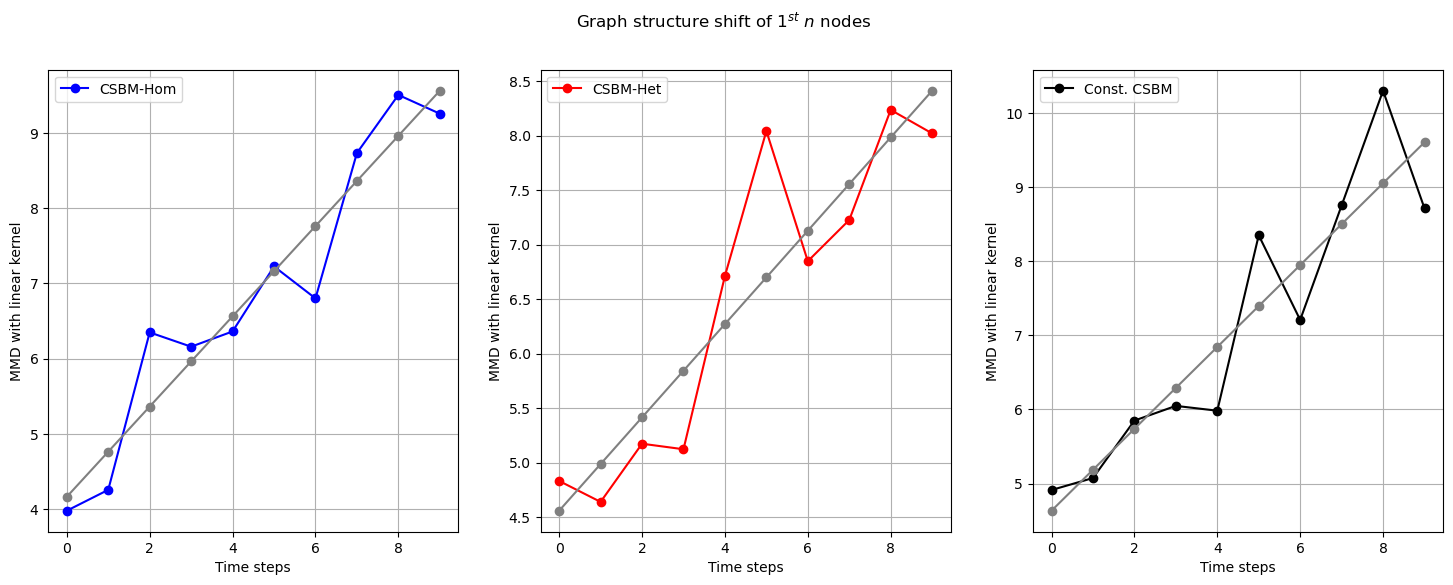

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle(r'Graph structure shift of $1^{st}$ $n$ nodes')

coefficiencts_hom = np.polyfit(time_steps, mmd_hom_first, 1)
poly_hom = np.poly1d(coefficiencts_hom)
y_fit_hom = poly_hom(time_steps)

coefficiencts_het = np.polyfit(time_steps, mmd_het_first, 1)
poly_het = np.poly1d(coefficiencts_het)
y_fit_het = poly_het(time_steps)

coefficiencts_const = np.polyfit(time_steps, mmd_const_first, 1)
poly_const = np.poly1d(coefficiencts_const)
y_fit_const = poly_const(time_steps)

axes[0].plot(time_steps, mmd_hom_first, marker='o', linestyle='-', color='b', label='CSBM-Hom')
axes[0].plot(time_steps, y_fit_hom, marker='o', linestyle='-', color='gray')
axes[1].plot(time_steps, mmd_het_first, marker='o', linestyle='-', color='r', label='CSBM-Het')
axes[1].plot(time_steps, y_fit_het, marker='o', linestyle='-', color='gray')
axes[2].plot(time_steps, mmd_const_first, marker='o', linestyle='-', color='black', label='Const. CSBM')
axes[2].plot(time_steps, y_fit_const, marker='o', linestyle='-', color='gray')
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
    ax.grid(True)
plt.savefig('structure_shift_n_separate.pdf', format='pdf')
plt.show()
plt.close()

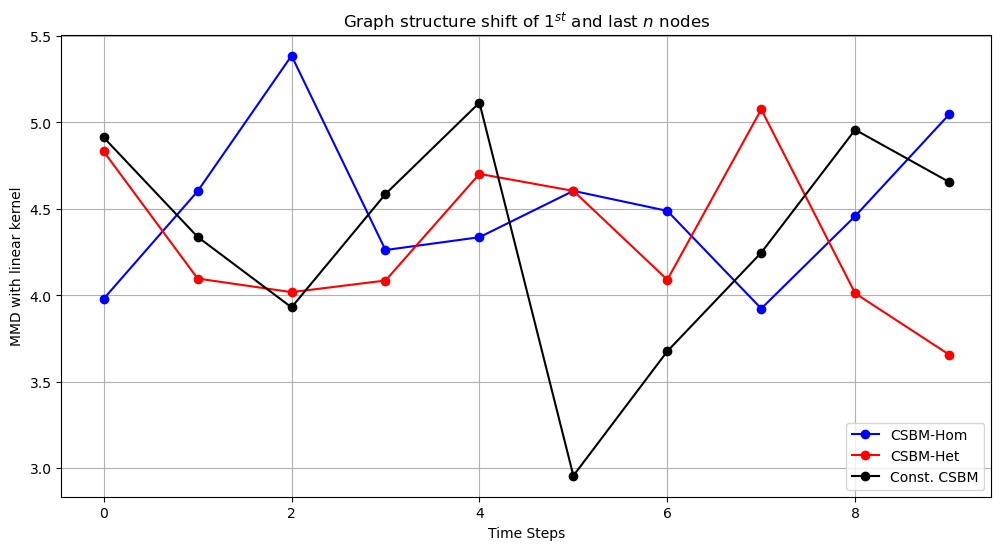

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmd_hom_curr, marker='o', linestyle='-', color='b', label='CSBM-Hom')
plt.plot(time_steps, mmd_het_curr, marker='o', linestyle='-', color='r', label='CSBM-Het')
plt.plot(time_steps, mmd_const_curr, marker='o', linestyle='-', color='black', label='Const. CSBM')

plt.title(r'Graph structure shift of $1^{st}$ and last $n$ nodes')
plt.xlabel('Time Steps')
plt.ylabel('MMD with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_curr_all.pdf', format='pdf')
plt.show()
plt.close()

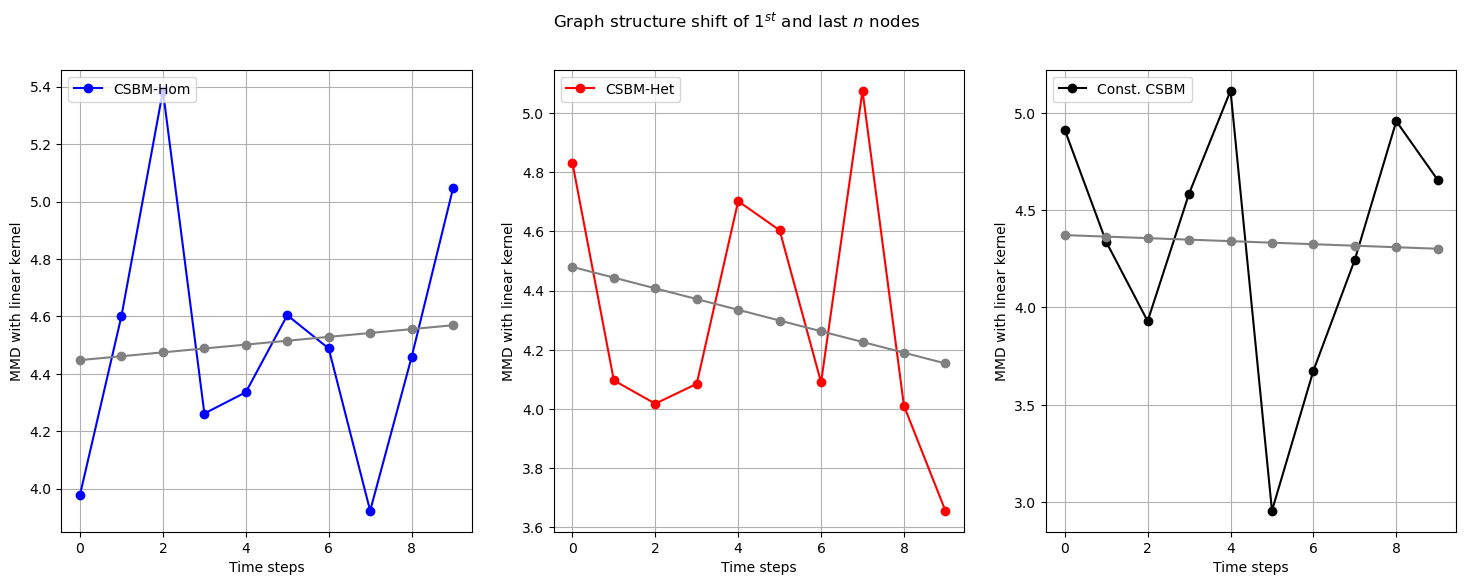

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle(r'Graph structure shift of $1^{st}$ and last $n$ nodes')

coefficiencts_hom = np.polyfit(time_steps, mmd_hom_curr, 1)
poly_hom = np.poly1d(coefficiencts_hom)
y_fit_hom = poly_hom(time_steps)

coefficiencts_het = np.polyfit(time_steps, mmd_het_curr, 1)
poly_het = np.poly1d(coefficiencts_het)
y_fit_het = poly_het(time_steps)

coefficiencts_const = np.polyfit(time_steps, mmd_const_curr, 1)
poly_const = np.poly1d(coefficiencts_const)
y_fit_const = poly_const(time_steps)

axes[0].plot(time_steps, mmd_hom_curr, marker='o', linestyle='-', color='b', label='CSBM-Hom')
axes[0].plot(time_steps, y_fit_hom, marker='o', linestyle='-', color='gray')
axes[1].plot(time_steps, mmd_het_curr, marker='o', linestyle='-', color='r', label='CSBM-Het')
axes[1].plot(time_steps, y_fit_het, marker='o', linestyle='-', color='gray')
axes[2].plot(time_steps, mmd_const_curr, marker='o', linestyle='-', color='black', label='Const. CSBM')
axes[2].plot(time_steps, y_fit_const, marker='o', linestyle='-', color='gray')
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
    ax.grid(True)
plt.savefig('structure_shift_n_separate.pdf', format='pdf')
plt.show()
plt.close()

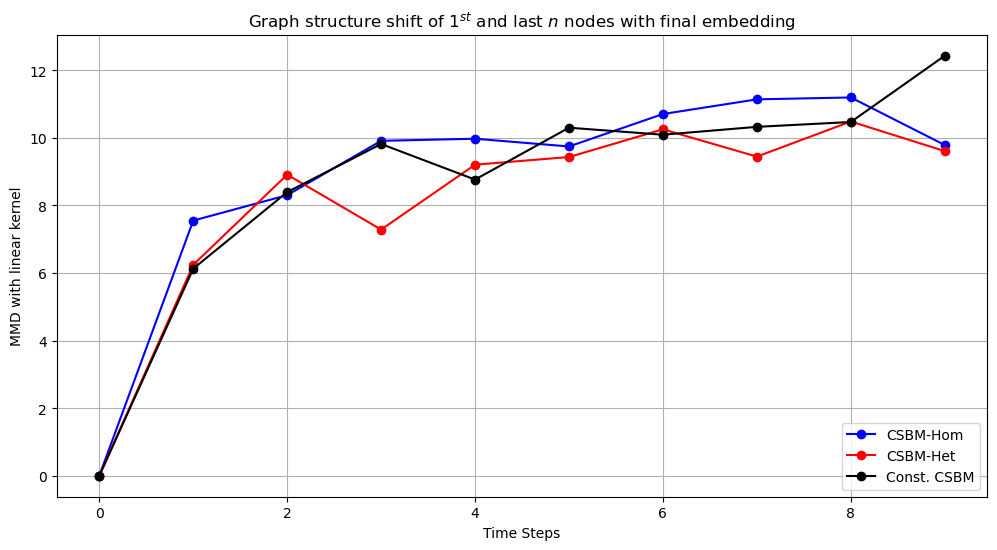

In [11]:
final_embedding_hom = model_training(csbm_hom)
final_embedding_het = model_training(csbm_het)
final_embedding_const = model_training(csbm_const)

mmd_hom_same = []
mmd_het_same = []
mmd_const_same = []

for t in range(len(time_steps)):
    mmd_hom_same.append(mmd_linear(final_embedding_hom[:n], final_embedding_hom[t * n: (t + 1) * n]))
    mmd_het_same.append(mmd_linear(final_embedding_het[:n], final_embedding_het[t * n: (t + 1) * n]))
    mmd_const_same.append(mmd_linear(final_embedding_const[:n], final_embedding_const[t * n: (t + 1) * n]))

# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmd_hom_same, marker='o', linestyle='-', color='b', label='CSBM-Hom')
plt.plot(time_steps, mmd_het_same, marker='o', linestyle='-', color='r', label='CSBM-Het')
plt.plot(time_steps, mmd_const_same, marker='o', linestyle='-', color='black', label='Const. CSBM')

plt.title(r'Graph structure shift of $1^{st}$ and last $n$ nodes with final embedding')
plt.xlabel('Time Steps')
plt.ylabel('MMD with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_same_all.pdf', format='pdf')
plt.show()
plt.close()

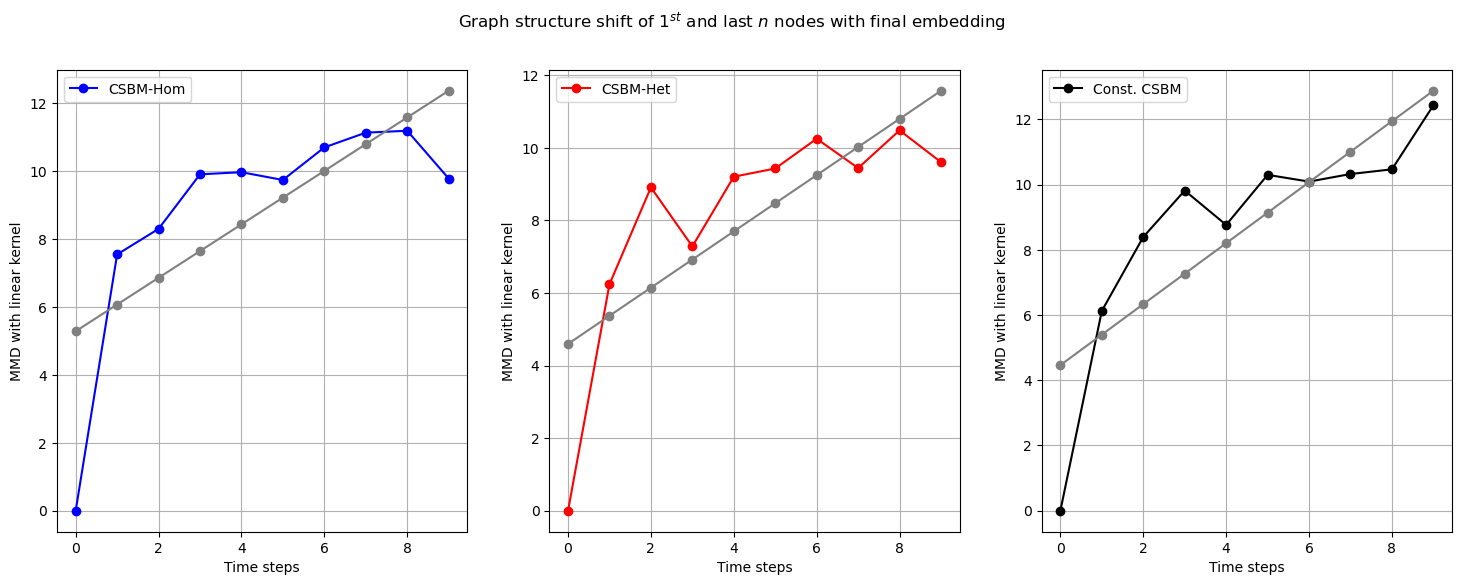

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle(r'Graph structure shift of $1^{st}$ and last $n$ nodes with final embedding')

coefficiencts_hom = np.polyfit(time_steps, mmd_hom_same, 1)
poly_hom = np.poly1d(coefficiencts_hom)
y_fit_hom = poly_hom(time_steps)

coefficiencts_het = np.polyfit(time_steps, mmd_het_same, 1)
poly_het = np.poly1d(coefficiencts_het)
y_fit_het = poly_het(time_steps)

coefficiencts_const = np.polyfit(time_steps, mmd_const_same, 1)
poly_const = np.poly1d(coefficiencts_const)
y_fit_const = poly_const(time_steps)

axes[0].plot(time_steps, mmd_hom_same, marker='o', linestyle='-', color='b', label='CSBM-Hom')
axes[0].plot(time_steps, y_fit_hom, marker='o', linestyle='-', color='gray')
axes[1].plot(time_steps, mmd_het_same, marker='o', linestyle='-', color='r', label='CSBM-Het')
axes[1].plot(time_steps, y_fit_het, marker='o', linestyle='-', color='gray')
axes[2].plot(time_steps, mmd_const_same, marker='o', linestyle='-', color='black', label='Const. CSBM')
axes[2].plot(time_steps, y_fit_const, marker='o', linestyle='-', color='gray')
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
    ax.grid(True)
plt.savefig('structure_shift_same_separate.pdf', format='pdf')
plt.show()
plt.close()

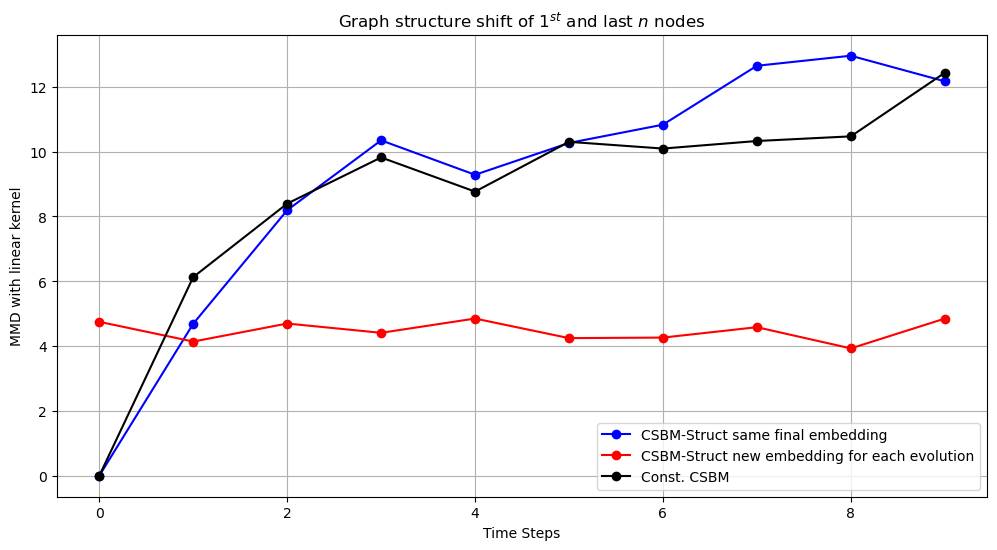

In [15]:
structure_csbm = StructureCSBM(n=n, classes=classes, dimensions=dimensions)
initial_embedding_struct = model_training(structure_csbm)

mmd_struct_diff = []
mmd_struct_same = []

for _ in range(len(time_steps)):
    embedding = model_training(structure_csbm)[-n:]
    mmd_struct_diff.append(mmd_linear(initial_embedding_struct, embedding))
    structure_csbm.evolve()

final_embedding = model_training(structure_csbm)
for t in range(len(time_steps)):
    start = t * n
    end = (t + 1) * n
    mmd_struct_same.append(mmd_linear(final_embedding[:n], final_embedding[start:end]))

plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmd_struct_same, marker='o', linestyle='-', color='b', label='CSBM-Struct same final embedding')
plt.plot(time_steps, mmd_struct_diff, marker='o', linestyle='-', color='r', label='CSBM-Struct new embedding for each evolution')
plt.plot(time_steps, mmd_const_same, marker='o', linestyle='-', color='black', label='Const. CSBM')

plt.title(r'Graph structure shift of $1^{st}$ and last $n$ nodes')
plt.xlabel('Time Steps')
plt.ylabel('MMD with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_struct_all.pdf', format='pdf')
plt.show()
plt.close()

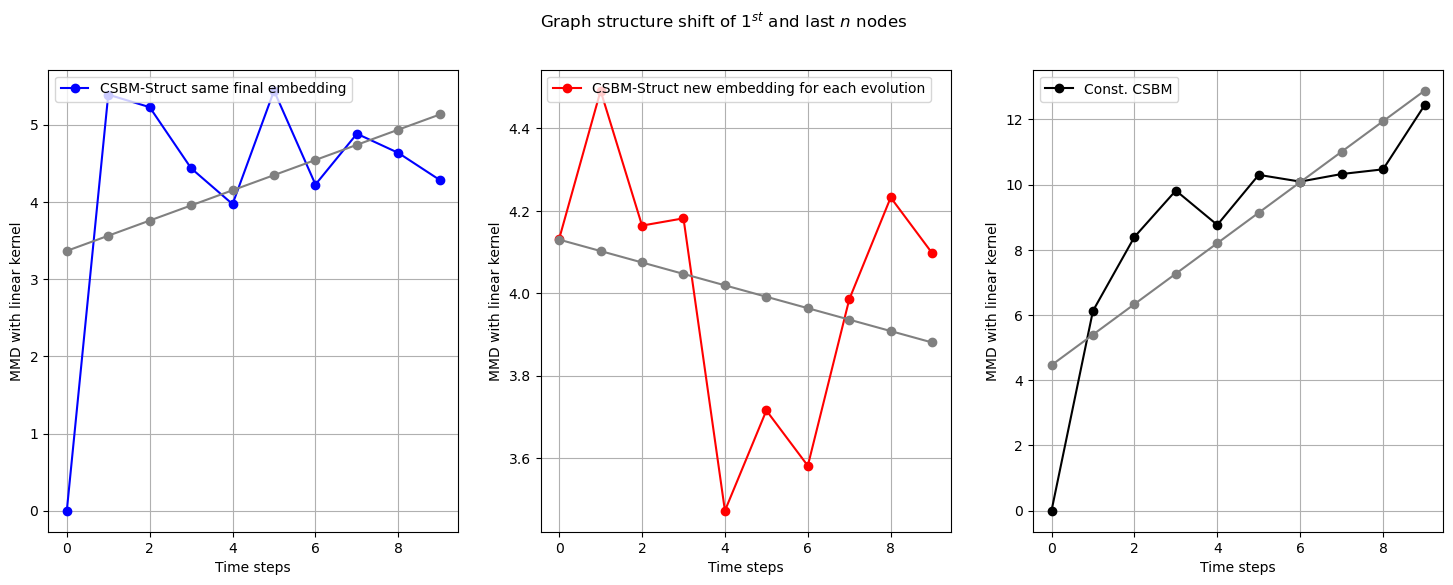

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle(r'Graph structure shift of $1^{st}$ and last $n$ nodes')

coefficiencts_hom = np.polyfit(time_steps, mmd_struct_same, 1)
poly_hom = np.poly1d(coefficiencts_hom)
y_fit_hom = poly_hom(time_steps)

coefficiencts_het = np.polyfit(time_steps, mmd_struct_diff, 1)
poly_het = np.poly1d(coefficiencts_het)
y_fit_het = poly_het(time_steps)

coefficiencts_const = np.polyfit(time_steps, mmd_const_same, 1)
poly_const = np.poly1d(coefficiencts_const)
y_fit_const = poly_const(time_steps)

axes[0].plot(time_steps, mmd_struct_same, marker='o', linestyle='-', color='b', label='CSBM-Struct same final embedding')
axes[0].plot(time_steps, y_fit_hom, marker='o', linestyle='-', color='gray')
axes[1].plot(time_steps, mmd_struct_diff, marker='o', linestyle='-', color='r', label='CSBM-Struct new embedding for each evolution')
axes[1].plot(time_steps, y_fit_het, marker='o', linestyle='-', color='gray')
axes[2].plot(time_steps, mmd_const_same, marker='o', linestyle='-', color='black', label='Const. CSBM')
axes[2].plot(time_steps, y_fit_const, marker='o', linestyle='-', color='gray')
for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
    ax.grid(True)
plt.savefig('structure_shift_struct_separate.pdf', format='pdf')
plt.show()
plt.close()